### The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past. They have chosen a random sample of users and emailed them. The email let the user know about a new feature implemented on the site. From the marketing team perspective, success is if the user clicks on the link inside of the email. This link takes the user to the company site.

### You are in charge of figuring out how the email campaign performed and were asked the following questions:

#### (1) What percentage of users opened the email and what percentage clicked on the link within the email?
#### (2) The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?
#### (3) By how much do you think your model would improve click-through-rate (defined as # of users who click on the link/total users who received the email). How would you test that?
#### (4) Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

### Load the package would be used

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

### Read in the data set

In [2]:
Email = pd.read_csv("../Datasets/email/email_table.csv")
Open = pd.read_csv("../Datasets/email/email_opened_table.csv")
Click = pd.read_csv("../Datasets/email/link_clicked_table.csv")

### Look into dataset

In [3]:
print(Email.shape)
print(Open.shape)
print(Click.shape)

print(Email.head)
print(Open.head)
print(Click.head)

print(Email.info)
print(Open.info)
print(Click.info)

print(len(Email["email_id"]) == len(pd.unique(Email["email_id"])))
print(len(Open["email_id"]) == len(pd.unique(Open["email_id"])))
print(len(Click["email_id"]) == len(pd.unique(Click["email_id"])))

(100000, 7)
(10345, 1)
(2119, 1)
<bound method NDFrame.head of        email_id   email_text email_version  hour    weekday user_country  user_past_purchases
0         85120  short_email  personalized     2     Sunday           US                    5
1        966622   long_email  personalized    12     Sunday           UK                    2
2        777221   long_email  personalized    11  Wednesday           US                    2
3        493711  short_email       generic     6     Monday           UK                    1
4        106887   long_email       generic    14     Monday           US                    6
...         ...          ...           ...   ...        ...          ...                  ...
99995    803504  short_email  personalized     4     Monday           US                    5
99996    899722   long_email  personalized     7   Saturday           US                    1
99997    449610   long_email  personalized    11   Saturday           UK                   

### Merge dataset

In [4]:
Open["open"] = 1
Click["click"] = 1
dat = Email.merge(Open, on = ["email_id"], how = "left").merge(Click, on = ["email_id"], how = "left")
dat["open"] = dat["open"].replace(np.nan, 0)
dat["click"] = dat["click"].replace(np.nan, 0)
list(dat.columns)

['email_id',
 'email_text',
 'email_version',
 'hour',
 'weekday',
 'user_country',
 'user_past_purchases',
 'open',
 'click']

### Data Visualization

#### Email text

Text(0, 0.5, 'Click Rate')

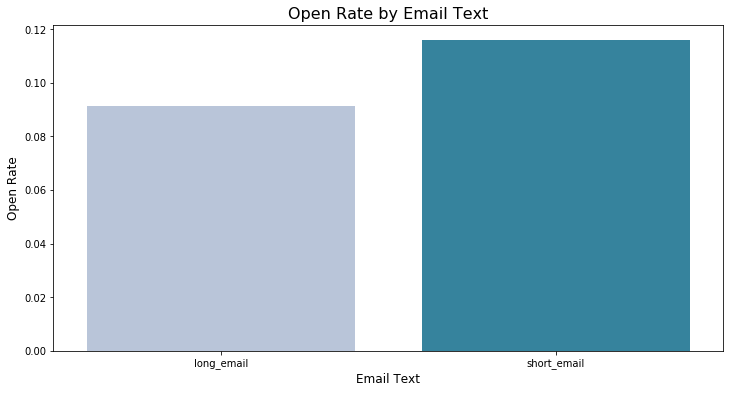

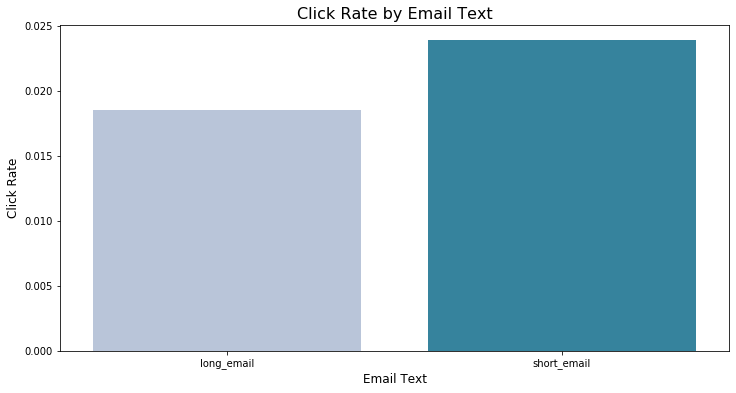

In [5]:
grp_text = dat[["email_text", "open", "click"]].groupby(["email_text"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "email_text", y = "open", data = grp_text, palette = "PuBuGn")
plt.title("Open Rate by Email Text", fontsize = 16)
plt.xlabel("Email Text", fontsize = 12)
plt.ylabel("Open Rate", fontsize = 12)

plt.figure(figsize = [12, 6])
sns.barplot(x = "email_text", y = "click", data = grp_text, palette = "PuBuGn")
plt.title("Click Rate by Email Text", fontsize = 16)
plt.xlabel("Email Text", fontsize = 12)
plt.ylabel("Click Rate", fontsize = 12)

#### Email Version

Text(0, 0.5, 'Click Rate')

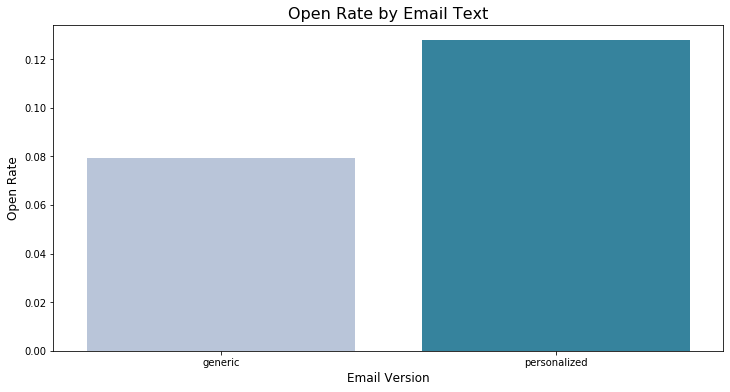

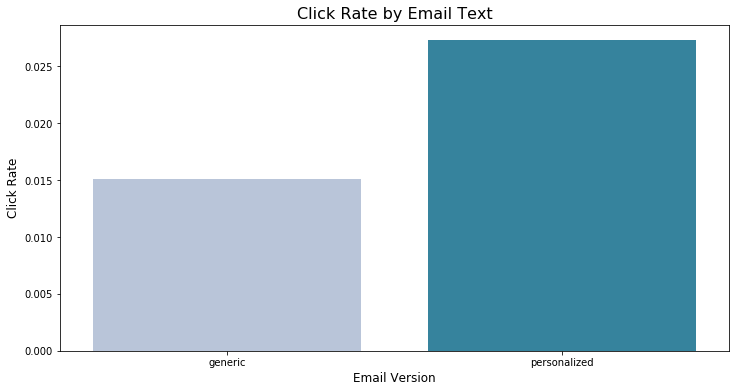

In [6]:
grp_version = dat[["email_version", "open", "click"]].groupby(["email_version"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "email_version", y = "open", data = grp_version, palette = "PuBuGn")
plt.title("Open Rate by Email Text", fontsize = 16)
plt.xlabel("Email Version", fontsize = 12)
plt.ylabel("Open Rate", fontsize = 12)

plt.figure(figsize = [12, 6])
sns.barplot(x = "email_version", y = "click", data = grp_version, palette = "PuBuGn")
plt.title("Click Rate by Email Text", fontsize = 16)
plt.xlabel("Email Version", fontsize = 12)
plt.ylabel("Click Rate", fontsize = 12)

#### Hour

Text(0, 0.5, 'Click Rate')

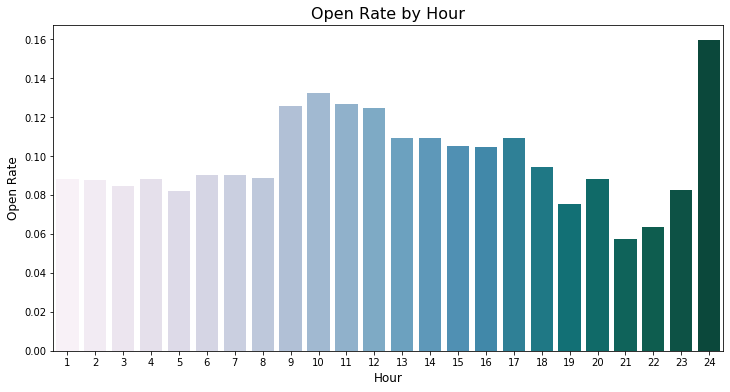

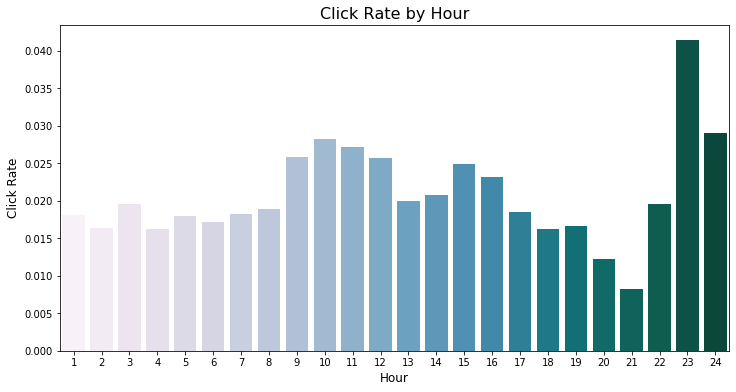

In [7]:
grp_hour = dat[["hour", "open", "click"]].groupby(["hour"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "hour", y = "open", data = grp_hour, palette = "PuBuGn")
plt.title("Open Rate by Hour", fontsize = 16)
plt.xlabel("Hour", fontsize = 12)
plt.ylabel("Open Rate", fontsize = 12)

plt.figure(figsize = [12, 6])
sns.barplot(x = "hour", y = "click", data = grp_hour, palette = "PuBuGn")
plt.title("Click Rate by Hour", fontsize = 16)
plt.xlabel("Hour", fontsize = 12)
plt.ylabel("Click Rate", fontsize = 12)

### Week of Day

Text(0, 0.5, 'Click Rate')

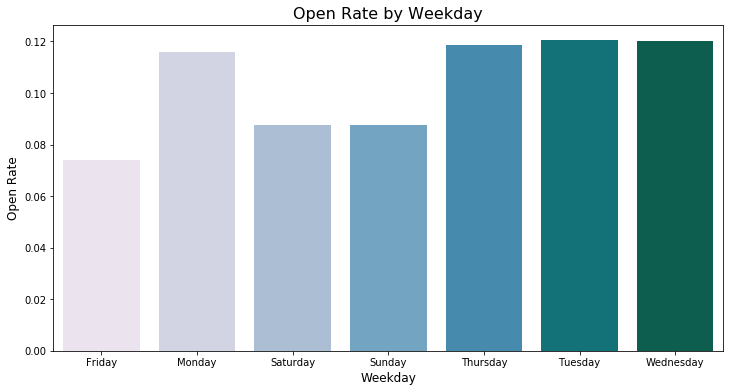

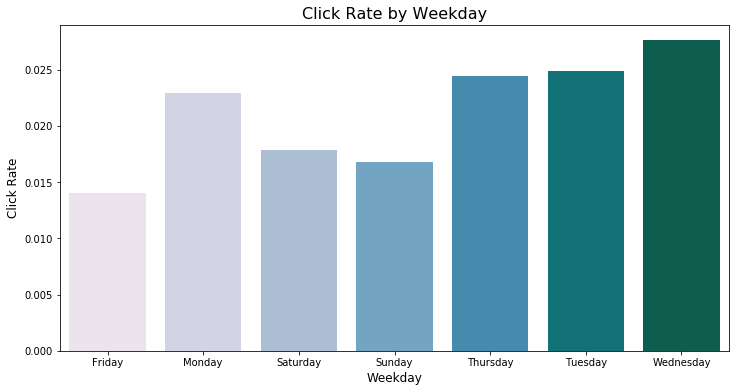

In [8]:
grp_weekday = dat[["weekday", "open", "click"]].groupby(["weekday"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "weekday", y = "open", data = grp_weekday, palette = "PuBuGn")
plt.title("Open Rate by Weekday", fontsize = 16)
plt.xlabel("Weekday", fontsize = 12)
plt.ylabel("Open Rate", fontsize = 12)

plt.figure(figsize = [12, 6])
sns.barplot(x = "weekday", y = "click", data = grp_weekday, palette = "PuBuGn")
plt.title("Click Rate by Weekday", fontsize = 16)
plt.xlabel("Weekday", fontsize = 12)
plt.ylabel("Click Rate", fontsize = 12)

### Country

Text(0, 0.5, 'Click Rate')

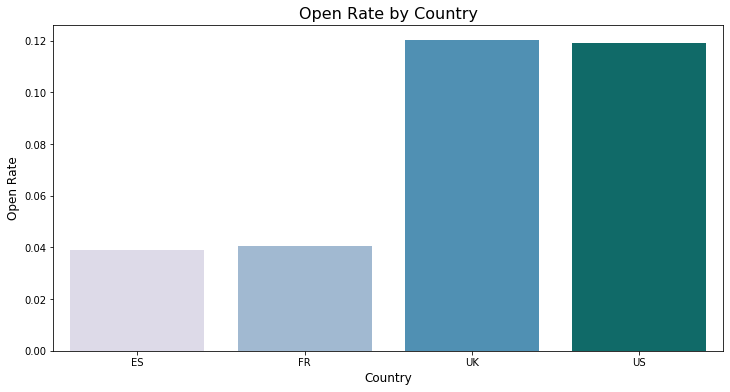

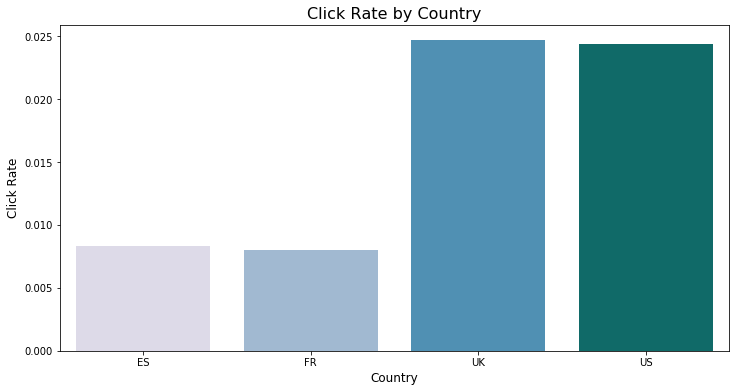

In [9]:
grp_country = dat[["user_country", "open", "click"]].groupby(["user_country"]).mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "user_country", y = "open", data = grp_country, palette = "PuBuGn")
plt.title("Open Rate by Country", fontsize = 16)
plt.xlabel("Country", fontsize = 12)
plt.ylabel("Open Rate", fontsize = 12)

plt.figure(figsize = [12, 6])
sns.barplot(x = "user_country", y = "click", data = grp_country, palette = "PuBuGn")
plt.title("Click Rate by Country", fontsize = 16)
plt.xlabel("Country", fontsize = 12)
plt.ylabel("Click Rate", fontsize = 12)

### \# of Past Purchases

Text(0, 0.5, 'Click Rate')

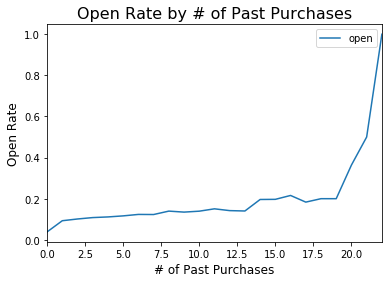

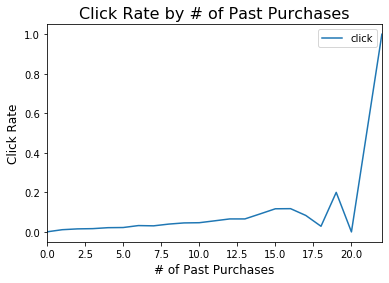

In [10]:
dat[["user_past_purchases", "open"]].groupby("user_past_purchases").mean().plot()
plt.title("Open Rate by # of Past Purchases", fontsize = 16)
plt.xlabel("# of Past Purchases", fontsize = 12)
plt.ylabel("Open Rate", fontsize = 12)

dat[["user_past_purchases", "click"]].groupby("user_past_purchases").mean().plot()
plt.title("Click Rate by # of Past Purchases", fontsize = 16)
plt.xlabel("# of Past Purchases", fontsize = 12)
plt.ylabel("Click Rate", fontsize = 12)

#### (1) What percentage of users opened the email and what percentage clicked on the link within the email?

In [11]:
print(dat["open"].mean())
print(dat["click"].mean())

0.10345
0.02119


#### (2) The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

##### Step 1: Construct a classify to predict the click-through-rate

In [12]:
#### Initialize H2O cluster
h2o.init()
h2o.remove_all()
dat_h2o = H2OFrame(dat)
dat_h2o["click"] = dat_h2o["click"].asfactor()
dat_h2o["email_text"] = dat_h2o["email_text"].asfactor()
dat_h2o["email_version"] = dat_h2o["email_version"].asfactor()
dat_h2o["weekday"] = dat_h2o["weekday"].asfactor()
dat_h2o["user_country"] = dat_h2o["user_country"].asfactor()
dat_h2o.summary()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.1" 2019-10-15; Java(TM) SE Runtime Environment (build 13.0.1+9); Java HotSpot(TM) 64-Bit Server VM (build 13.0.1+9, mixed mode, sharing)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmp_lj45htd
  JVM stdout: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmp_lj45htd/h2o_jinliu_started_from_python.out
  JVM stderr: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmp_lj45htd/h2o_jinliu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_jinliu_2uudl4
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
type,int,enum,enum,int,enum,enum,int,int,enum
mins,8.0,,,1.0,,,0.0,0.0,
mean,498690.1961600017,,,9.059300000000105,,,3.8784500000000186,0.10345,
maxs,999998.0,,,24.0,,,22.0,1.0,
sigma,289230.72753429407,,,4.439637441706958,,,3.1961097835771426,0.3045472459081676,
zeros,0,,,0,,,13877,89655,
missing,0,0,0,0,0,0,0,0,0
0,85120.0,short_email,personalized,2.0,Sunday,US,5.0,0.0,0
1,966622.0,long_email,personalized,12.0,Sunday,UK,2.0,1.0,1
2,777221.0,long_email,personalized,11.0,Wednesday,US,2.0,0.0,0


In [13]:
index = dat_h2o["click"].stratified_split(test_frac = 0.34, seed = 2020)
train_dat = dat_h2o[index == "train"]
test_dat = dat_h2o[index == "test"]
X = ["email_text", "email_version", "hour", "weekday", "user_country", "user_past_purchases"]
Y = "click"
RF = H2ORandomForestEstimator(balance_classes = False, ntrees = 100, max_depth = 20, 
                               mtries = -1, seed = 2019, score_each_iteration = True)
RF.train(x = X, y = Y, training_frame = train_dat)

drf Model Build progress: |███████████████████████████████████████████████| 100%


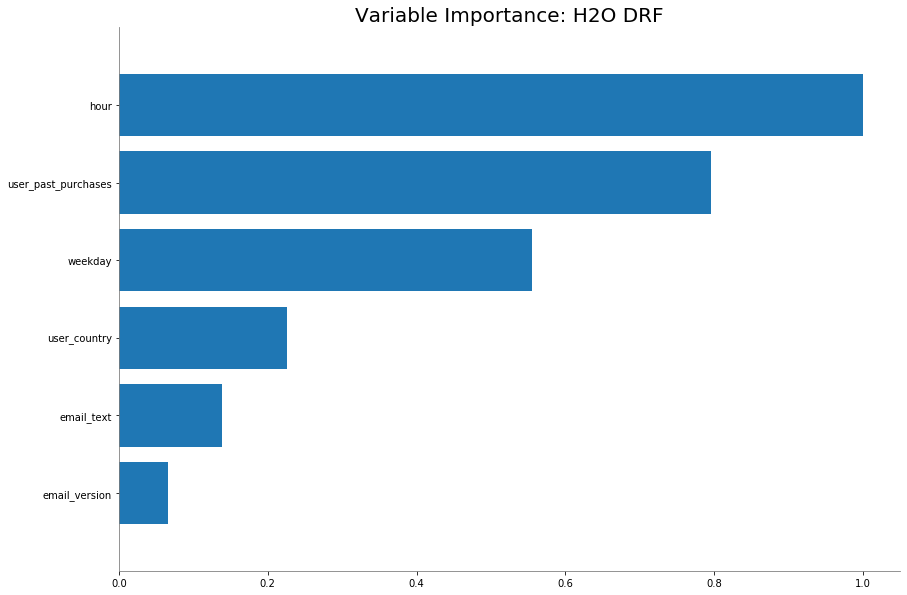

In [14]:
RF.varimp_plot()

##### Step 2: Make predictions, fix the variables user country and user_past_purchases and decide other four factors to maximize predicted CRT

In [15]:
test_pred = RF.predict(test_dat).as_data_frame()["p1"].values
test_df = test_dat.as_data_frame()
test_df["predicted_CRT"] = test_pred

drf prediction progress: |████████████████████████████████████████████████| 100%


In [16]:
click_group = test_df[["predicted_CRT", "user_country", "user_past_purchases"]].groupby(["user_country", "user_past_purchases"]).max().reset_index()
click_group.head()

,user_country,user_past_purchases,predicted_CRT
0,ES,0,0.018132
1,ES,1,0.242653
2,ES,2,0.258060
3,ES,3,0.209310
4,ES,4,0.438053


In [17]:
personalized = click_group.merge(test_df, on = ["predicted_CRT", "user_country", "user_past_purchases"], how = "left")
personalized = personalized[["predicted_CRT", "user_country", "user_past_purchases", "email_text", "email_version", "hour", "weekday"]]
personalized.head()

,predicted_CRT,user_country,user_past_purchases,email_text,email_version,hour,weekday
0,0.018132,ES,0,short_email,generic,10,Tuesday
1,0.242653,ES,1,short_email,personalized,8,Sunday
2,0.258060,ES,2,short_email,personalized,15,Thursday
3,0.209310,ES,3,long_email,personalized,10,Monday
4,0.209310,ES,3,long_email,personalized,10,Monday


#### (3) By how much do you think your model would improve click-through-rate (defined as # of users who click on the link/total users who received the email). How would you test that?

In [18]:
personalized_pred = RF.predict(H2OFrame(personalized)).as_data_frame()["p1"].values
personalized_pred.mean()

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


0.2885654766157269

Conduct an A/B test for 2~3 weeks.

#### (4) Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

See my R solution.